# Churn model voor het bedrijf Telco

In [78]:
import pandas as pd
# klasse om data te splitsen in een leer- en testset
from sklearn.model_selection import train_test_split  
# libs voor grafieken
import seaborn as snb                                 
import matplotlib.pyplot as plt
# libs nodig om de dataPipeLine te maken
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
# libs voor decisiontree model
from sklearn.tree import DecisionTreeClassifier   # module voor classifier
from sklearn.model_selection import RandomizedSearchCV  # module die via cross validation verschillende hyperparametes uittest
from sklearn.metrics import accuracy_score  # globale score voor classificatie
from sklearn import tree  # module om decisiontree te tekenen
from sklearn.metrics import confusion_matrix  # om matrix te maken die de 'nauwkeurigheid' per klasse toont
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

## Data verkennen

In [2]:
df = pd.read_csv("../data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


 ### Verklaring kolommen

In [4]:
# customer 1 lijn of meerdere lijnen ?
print(len(df.customerID.unique()))

7043


In [5]:
# per customer 1 lijn
# gender --> geslacht
print(df.gender.unique())

['Female' 'Male']


In [6]:
# SeniorCitizen
print(df.SeniorCitizen.unique())

[0 1]


In [7]:
# Partner --> ja of nee
print(df.Partner.unique())

['Yes' 'No']


In [8]:
# Dependents --> ten laste 
print(df.Dependents.unique())

['No' 'Yes']


In [9]:
# Tenure --> aantal maanden klant
print(df.tenure.unique())

[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


In [11]:
# PhoneService --> telefoon abonnenment
print(df.PhoneService.unique())

['No' 'Yes']


In [12]:
# MultipleLines --> meerdere lijnen?
print(df.MultipleLines.unique())

['No phone service' 'No' 'Yes']


In [13]:
# InternetService --> soort internet verbinding
print(df.InternetService.unique())

['DSL' 'Fiber optic' 'No']


In [14]:
# OnlineSecurity --> online beveiliging
print(df.OnlineSecurity.unique())

['No' 'Yes' 'No internet service']


In [15]:
# OnlineBackup --> online backup
print(df.OnlineBackup.unique())

['Yes' 'No' 'No internet service']


In [16]:
# DeviceProtection --> systeem beveiliging
print(df.DeviceProtection.unique())

['No' 'Yes' 'No internet service']


In [17]:
# TechSupport --> technische support
print(df.TechSupport.unique())

['No' 'Yes' 'No internet service']


In [18]:
# StreamingTV --> TV streamen
print(df.StreamingTV.unique())

['No' 'Yes' 'No internet service']


In [19]:
# StreamingMovies --> films streamen
print(df.StreamingMovies.unique())

['No' 'Yes' 'No internet service']


In [20]:
# Contract --> soort contract
print(df.Contract.unique())

['Month-to-month' 'One year' 'Two year']


In [21]:
# PaperlessBilling --> electronische factuur ?
print(len(df.PaperlessBilling))
print(df.PaperlessBilling.unique().size)

7043
2


In [22]:
# PaymentMethod --> betaalmethode
print(df.PaymentMethod.unique())

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [23]:
# MonthlyCharges
print(df.MonthlyCharges.unique())

[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]


In [24]:
# TotalCharges !!!!strings!!!!
print(df.TotalCharges.unique())

['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


In [25]:
# Churn --> klant weggelopen ?
print(df.Churn.unique())

['No' 'Yes']


In [26]:
# Kolom TotalCharges zijn strings, maar zouden getallen moeten zijn
# sommigen bevatten een spatie
print(df[df.TotalCharges == ' '])

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

In [27]:
# omzetten lege strings naar '0'
df.TotalCharges = df.TotalCharges.str.replace(' ','0')
# nu omzetten naar float
df.TotalCharges = df.TotalCharges.astype('float')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Maken van train set en test set

In [29]:
train_set,test_set = train_test_split(df,test_size=0.3,random_state=42)
# random_state is randomseed voor de random functie
print('aantal entries in train_set:', len(train_set))
print('aantal entries in test_set: ', len(test_set))
print('stukje inhoud train_set:')
train_set.head()

aantal entries in train_set: 4930
aantal entries in test_set:  2113
stukje inhoud train_set:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1695,4906-ZHGPK,Male,0,Yes,Yes,54,Yes,Yes,DSL,No,...,No,Yes,Yes,No,One year,Yes,Electronic check,70.70,3770.00,No
1095,7439-DKZTW,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.55,80.55,No
3889,2592-HODOV,Male,0,No,No,13,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.30,259.65,No
3667,7826-VVKWT,Female,1,Yes,Yes,24,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Two year,Yes,Electronic check,96.55,2263.45,No
2902,1658-TJVOA,Female,1,No,No,6,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.10,450.90,No


## Patronen in churn detecteren aan de hand van visuele analyse

### Procentueel aantal churners

In [30]:
yes_no_churn = train_set.Churn.value_counts()
print(yes_no_churn)

No     3635
Yes    1295
Name: Churn, dtype: int64


In [31]:
# ophalen van No, Yes uit serie (=index van serie)
labels = list(yes_no_churn.index)
# ophalen van de waarden horende bij Yes en No
values = list(yes_no_churn.values)
print("labels:",labels,"values:",values)

labels: ['No', 'Yes'] values: [3635, 1295]


In [32]:
values_p = [values[0]*100/sum(values),values[1]*100/sum(values)]
print(values_p)

[73.73225152129818, 26.267748478701826]


([<matplotlib.patches.Wedge at 0x7f7341590a90>,
 [Text(-0.7462304484696153, 0.8081708468986226, 'No'),
  Text(0.7462305998024334, -0.8081707071643345, 'Yes')],
 [Text(-0.4070347900743356, 0.4408204619447032, '73.73%'),
  Text(0.40703487261950916, -0.44082038572600063, '26.27%')])

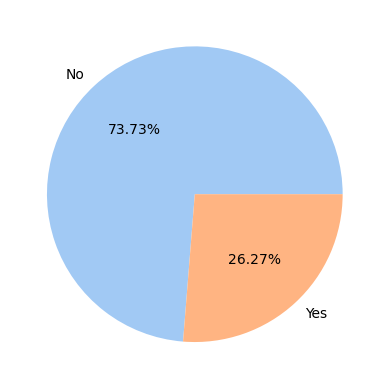

In [33]:
# kiezen van een kleurenpalet waaruit eerste 5 elementen genomen worden
colors = snb.color_palette('pastel')[0:5]
plt.pie(values_p,labels=labels,colors=colors,autopct='%.2f%%')

### Invloed van geslacht op churn

<Axes: xlabel='Churn', ylabel='count'>

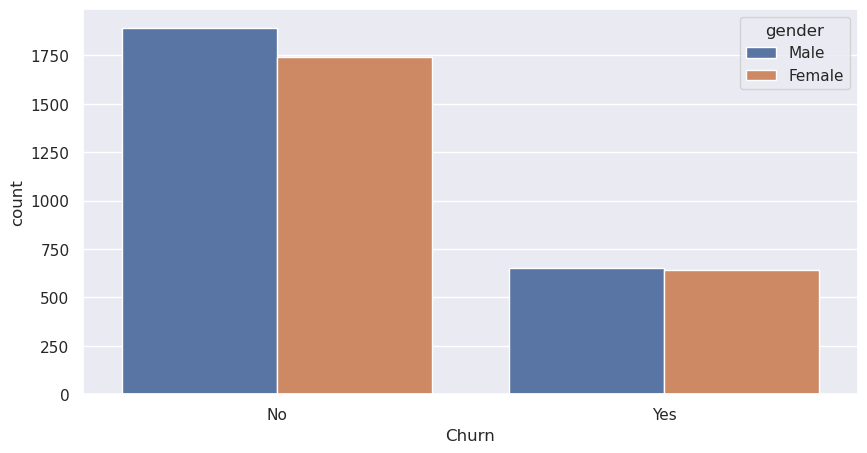

In [34]:
snb.set(rc={'figure.figsize':(10,5)})
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.gender)

### Invloed van gepensioneerd zijn op churn

<Axes: xlabel='Churn', ylabel='count'>

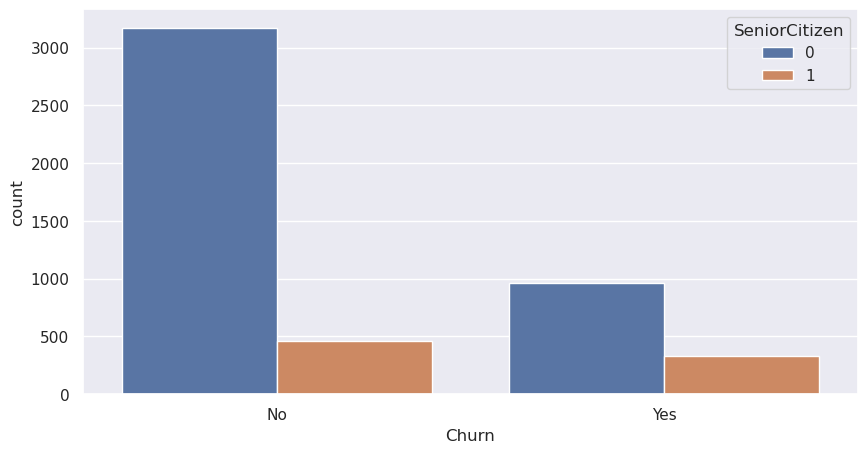

In [35]:
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.SeniorCitizen)

### Invloed van al dan niet een partner op churn 

<Axes: xlabel='Churn', ylabel='count'>

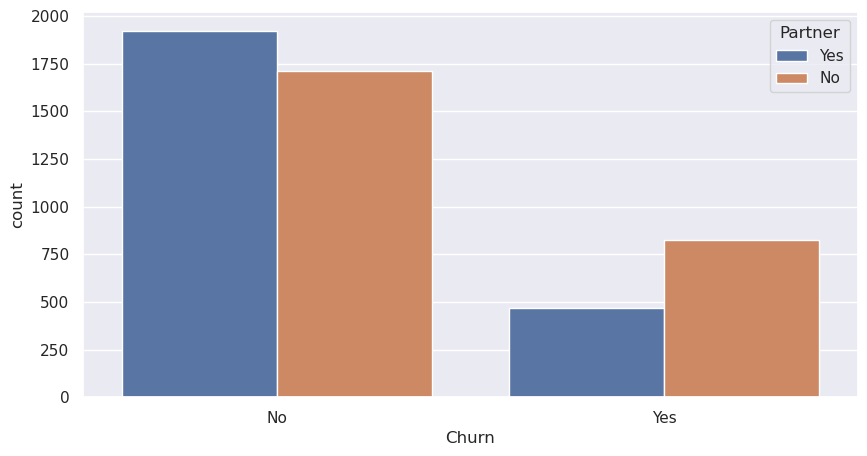

In [36]:
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.Partner)

# Invloed van aantal maanden klant op churn 

<Axes: xlabel='tenure', ylabel='count'>

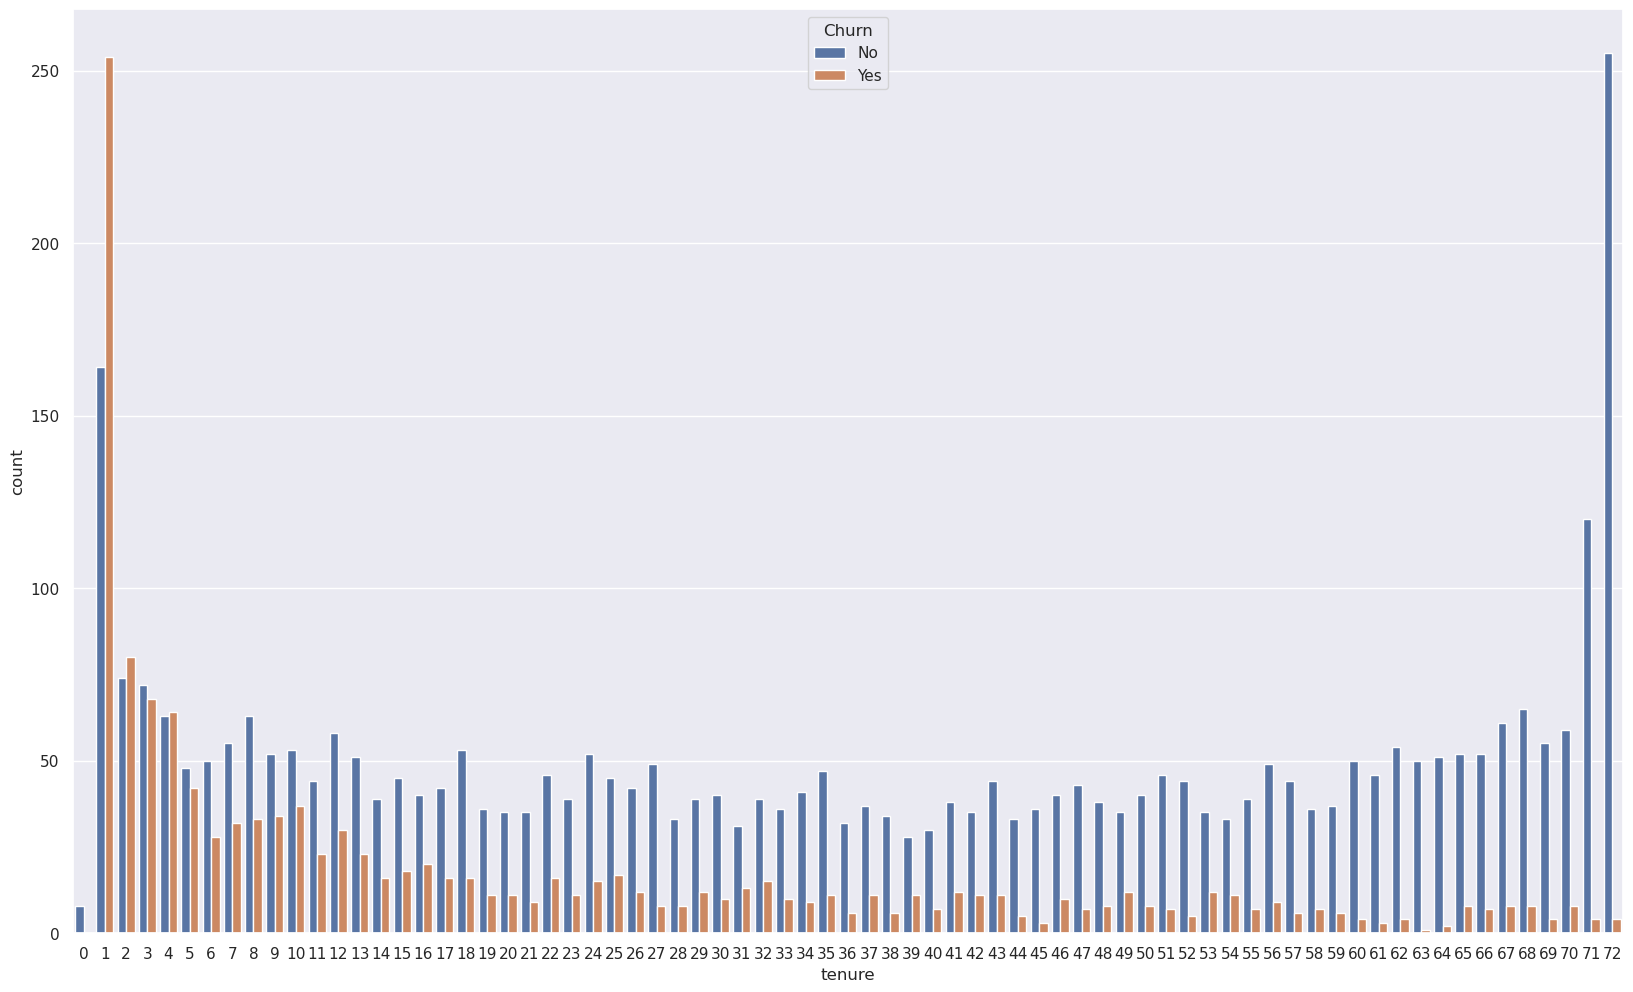

In [37]:
snb.set(rc={'figure.figsize':(20,12)})
snb.countplot(x=train_set.tenure,data=train_set,hue=train_set.Churn)

### Invloed maandelijks te betalen bedrag op churn

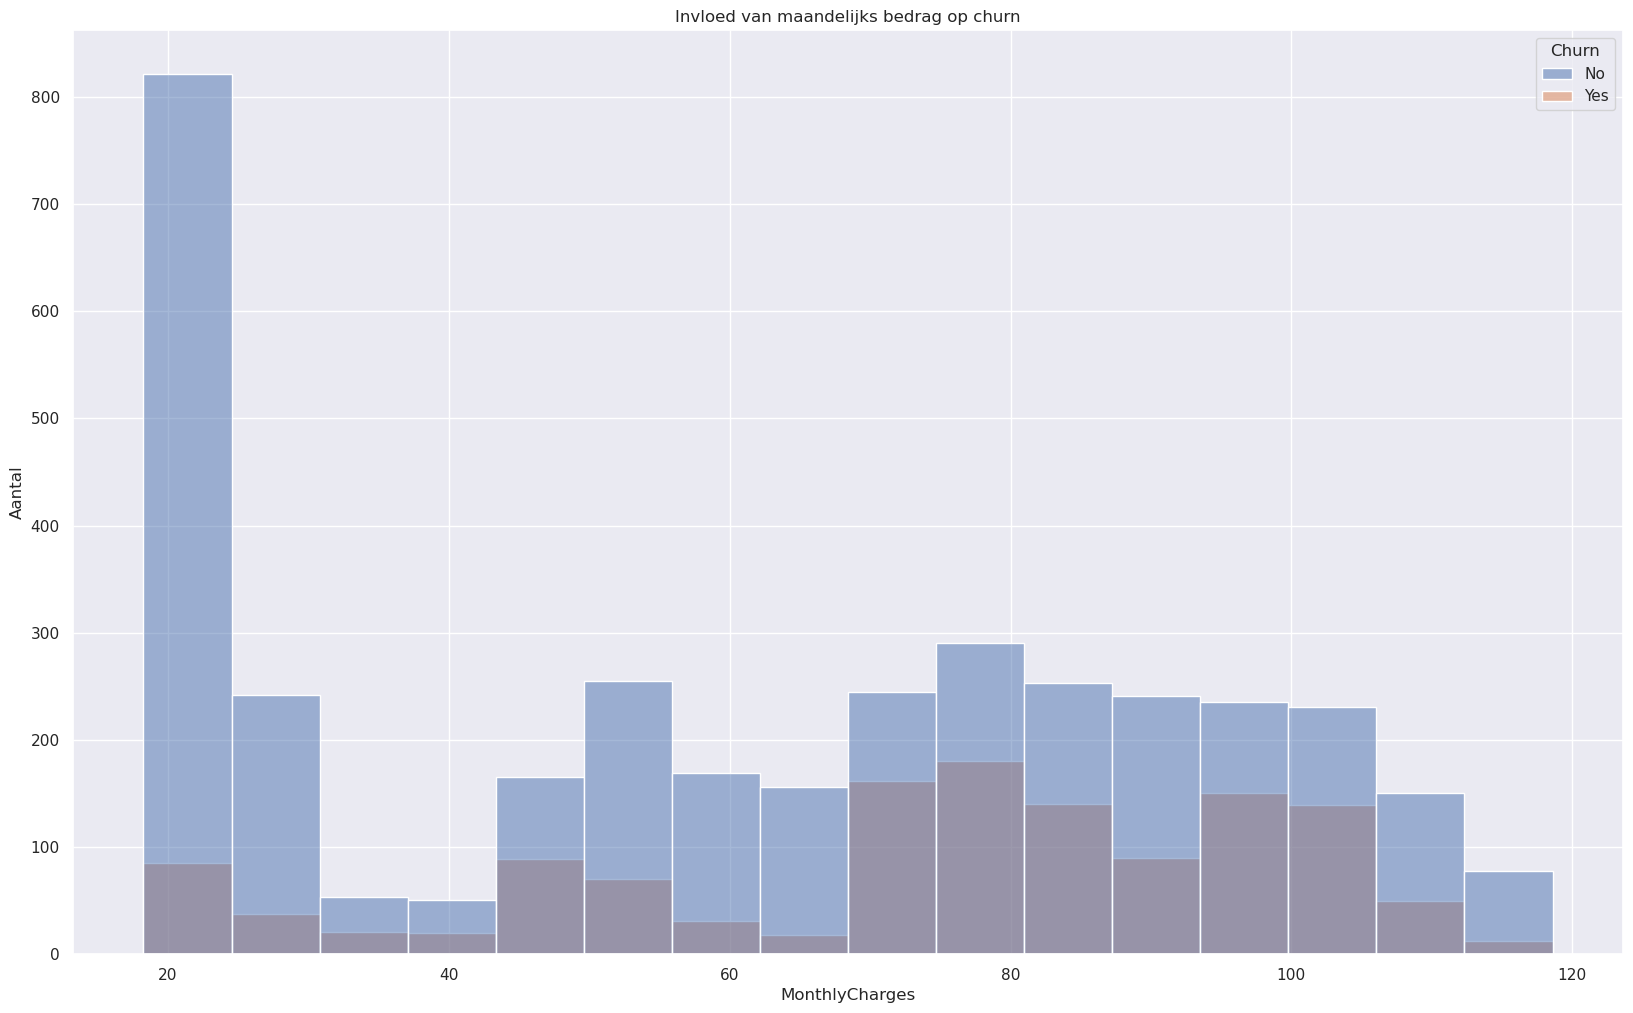

In [38]:
#snb.countplot(x=train_set.MonthlyCharges,data=train_set,hue=train_set.Churn)
fig = snb.histplot(x=train_set.MonthlyCharges,data=train_set,hue=train_set.Churn)
# naam y-as veranderen
fig.set_ylabel('Aantal')
# naam titel veranderen
fig.set_title('Invloed van maandelijks bedrag op churn')
# pointer naar grafiek ophalen
fig_tosave = fig.get_figure()
# grafiek opslaan
fig_tosave.savefig('invloed_maandbedrag_op_churn.png')

### Invloed soort internet connectie op churn 

<Axes: xlabel='Churn', ylabel='count'>

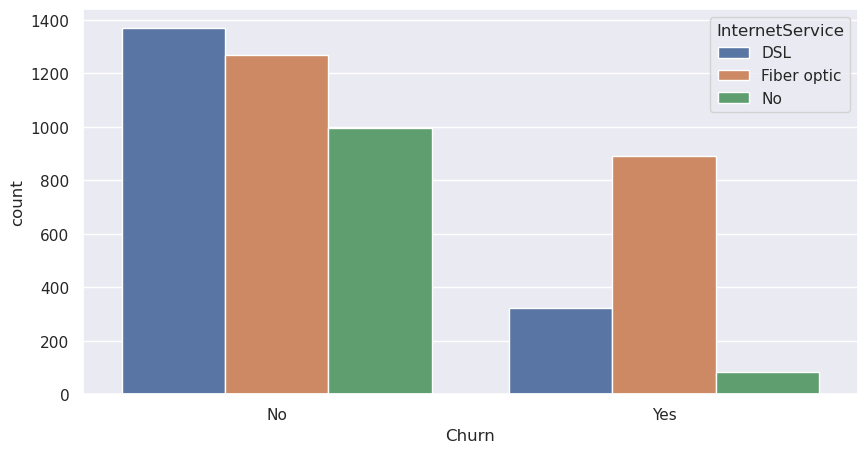

In [39]:
snb.set(rc={'figure.figsize':(10,5)})
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.InternetService)

### Invloed van tech support op churn

<Axes: xlabel='Churn', ylabel='count'>

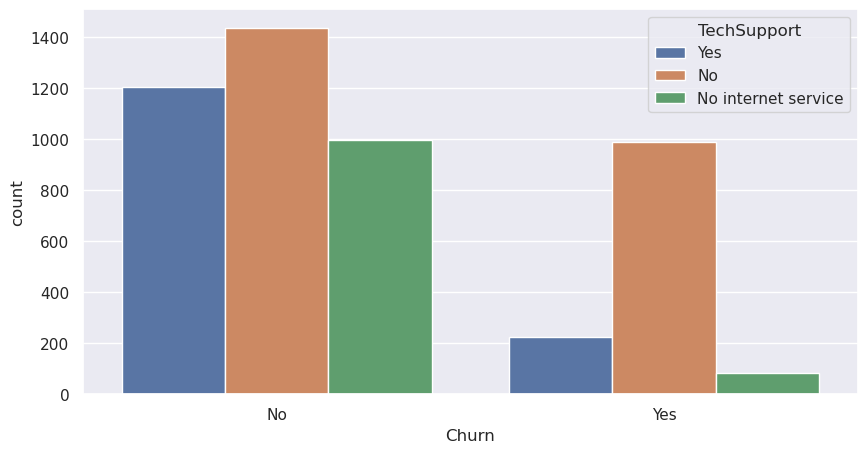

In [40]:
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.TechSupport)

### Invloed van personen ten laste op churn 

<Axes: xlabel='Churn', ylabel='count'>

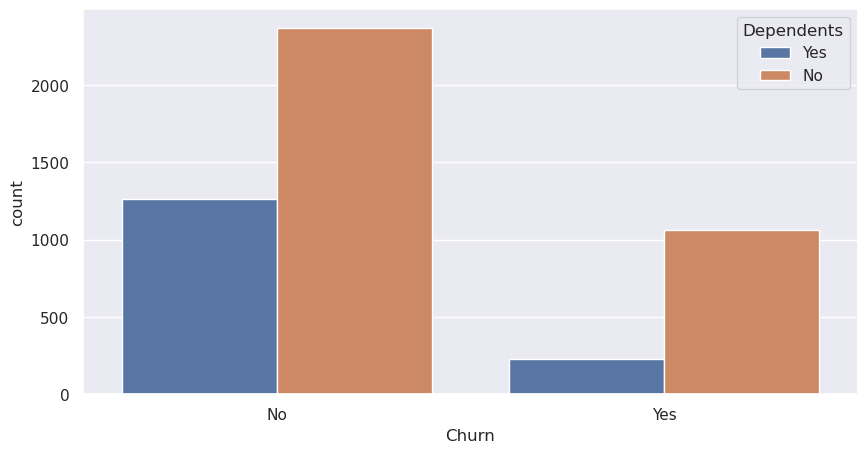

In [41]:
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.Dependents)

### Invloed van telefoon service op churn

<Axes: xlabel='Churn', ylabel='count'>

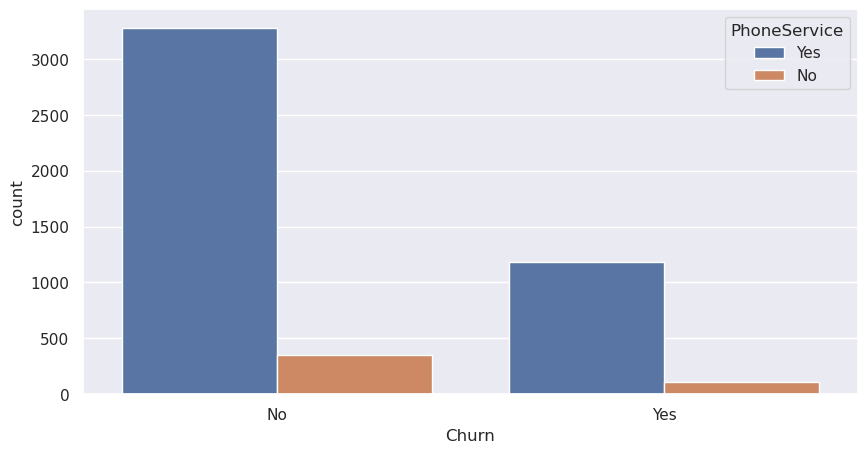

In [42]:
snb.countplot(x=train_set.Churn,data=train_set,hue=train_set.PhoneService)

## Maken van de DataPipeLine

In [43]:
cols_to_del = ['customerID']  # kolommen om te verwijderen
cols = train_set.columns
num_features = ['tenure','MonthlyCharges','TotalCharges']
target = 'Churn'
cat_features = []  # voor de niet numerieke velden beginnen met lege lijst
for c in cols:     # alle kolommen overlopen
    if c in cols_to_del:   # zit in kolommen te verwijderen, volgende stap
        continue
    if c in num_features:  # zit in numverieke kolommen, volgende stap
        continue
    if c == target:        # is target, volgende stap
        continue
    cat_features.append(c) # toevoegen aan cat_features
print(cat_features)
cols_change_zero_to_nan = ['TotalCharges']

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [44]:
def preprocessData(data,cols_change_0,cols_del,cols_num,cols_cat,target,dataPipeLine=None):
    
    # data opkuisen
    try:
        # kolommen waarin nullen zijn. Nullen vervangen door NaN (Not a Number)
        for c in cols_change_0:
            data[c] = data[c].replace({'0':np.nan, ' ':np.nan, 0:np.nan})
        # drop alle rijen die NaNs bevatten
        data = data.dropna()
        # kolommen die overbodig zijn verwijderen
        data.drop(columns=cols_del)
    except Exception as E:
        print(E)
        print('probleem met droppen van kolommen of niet geldige data.')
    # bepalen target en features
    y = data[target] 
    X = data.drop(columns=[target])  # features
    
    if dataPipeLine is None:
        # transformatie voor de num features
        scaler = MinMaxScaler(feature_range=(0,1))
        # transformatie voor niet numerieke features
        # OneHotEncoder wordt gebruikt bij features die geen bepaalde rangorde hebben.
        # drop='if_binary' zorgt ervoor dat een kolom met 2 waarden dezelfde kolom blijft die de waarde 1 en 0
        # zal bevatten vb no -> 0 en yes -> 1
        # kolommen met meer dan 2 waarden worden uitgebreid tot meerdere kolommen afhankelijk van het
        # aantal waarden
        o_enc = OneHotEncoder(drop='if_binary')    
        # Hier worden alle transformaties samen gebracht. Iedere transformatie is een tuple met 3 elementen :
        # 1ste = naam, 2de = transformatie, 3de = op welke features
        col_trans = ColumnTransformer(transformers=[('num',scaler,cols_num),('cat',o_enc,cols_cat)])
        # Maken van de PipeLine
        process = Pipeline(steps=[('coltrans',col_trans)])
        # De uiteidelijke transformatie
        X_res = process.fit_transform(X)
        # met drop_first blijft y 1 kolom en wordt target omgezet (yes/no)
        y = pd.get_dummies(y,drop_first=True)
        return X_res,y,process
    
    else:  # transformatie is al geleerd, dus enkel nog uitvoeren
        X_res = dataPipeLine.transform(X)
        y = pd.get_dummies(y,drop_first=True)
        return X_res,y,process
     

### Leer data door de dataPipeLine sturen

In [45]:
dataprocess = None
X,y,dataprocess = preprocessData(train_set,cols_change_zero_to_nan,cols_to_del,num_features,cat_features,
                                 target,dataprocess)
print("Getransformeerde features:")
print(X)
print("Getransformeerde target:")
print(y[:10])
print('DataPipeLine')
print(dataprocess)

Getransformeerde features:
[[0.74647887 0.52267065 0.43286407 ... 0.         1.         0.        ]
 [0.         0.62082711 0.00712555 ... 0.         1.         0.        ]
 [0.16901408 0.01046338 0.02779252 ... 1.         0.         0.        ]
 ...
 [0.15492958 0.02889885 0.03314678 ... 0.         1.         0.        ]
 [0.15492958 0.80916791 0.1363201  ... 0.         1.         0.        ]
 [0.35211268 0.01544594 0.05060005 ... 1.         0.         0.        ]]
Getransformeerde target:
      Yes
1695    0
1095    0
3889    0
3667    0
2902    0
1630    0
4294    0
1881    0
4710    0
1612    1
DataPipeLine
Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_b

## Modellen uittesten

### Model decisiontreeclassifier

In [46]:
dtc = DecisionTreeClassifier()  # object aanmaken
grid = {'max_depth':[4,12,16,24,32,40,64],'min_samples_leaf':[2,4,8,10],'min_samples_split':[2,4,8,10]}
# max_depth : maximale diepte van de tree
# min_samples_leaf : minimaal aantal datapunten om nog een node te zijn
# min_samples_split : minimaal aantal datapunten om een node nog verder uite te splitsen
random_cv = RandomizedSearchCV(dtc,grid,cv=4,random_state=42)  # maken randomVC object
random_cv.fit(X,y)  # fitten met verschillende combinaties van hyperparameters
best = random_cv.best_estimator_  # het best presterende model ophalen
pred_y = best.predict(X)  # Voorspellen met dit model (nog met leerset)
print('accuracy:',accuracy_score(y,pred_y))  
# meten van de prestatie van het model mbv accuracy = (#voorspelde yes + #voorspelde no) / #totaal
print('hyperparameters voor het beste model',random_cv.best_params_)

accuracy: 0.7903291344981714
hyperparameters voor het beste model {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}


### Beste features

In [47]:
print('belangrijkheid features:')
print(best.feature_importances_)

belangrijkheid features:
[0.11635595 0.03743221 0.02629599 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.08544376 0.         0.15332149 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00826397 0.55224333 0.0206433  0.         0.
 0.         0.         0.         0.        ]


### Features reductie : belangrijkheid > 3% 

In [48]:
# belangrijkheid features ophalen
best_features = best.feature_importances_
# lijst met indexen voor features > 3%
indexes_best_features = []
# door lijst best_features lopen
for i in range(len(best_features)):
    # feature > 3%
    if best_features[i]>0.03:
        # index bewaren
        indexes_best_features.append(i)
# enkel kolommen met belangrijkheid feature > 3% behouden       
X_red = X[:,indexes_best_features]
print(X_red)

[[0.74647887 0.52267065 0.         1.         0.        ]
 [0.         0.62082711 1.         1.         1.        ]
 [0.16901408 0.01046338 0.         0.         0.        ]
 ...
 [0.15492958 0.02889885 0.         0.         1.        ]
 [0.15492958 0.80916791 1.         1.         1.        ]
 [0.35211268 0.01544594 0.         0.         0.        ]]


## Testen beste model met minder features

In [49]:
dtc_5f = DecisionTreeClassifier(max_depth=4,min_samples_split=2,min_samples_leaf=4)
dtc_5f.fit(X_red,y)
pred_y_red = dtc_5f.predict(X_red)
print('accuracy:',accuracy_score(y,pred_y_red)) 

accuracy: 0.7895164567249086


### De decisiontree grafisch voorstellen

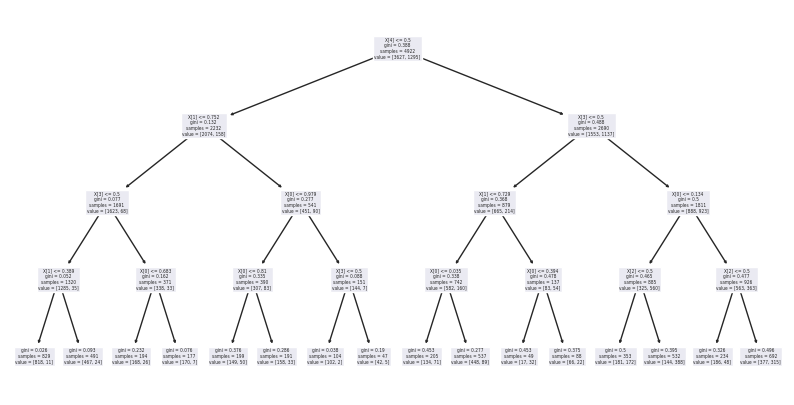

In [50]:
tree.plot_tree(dtc_5f);

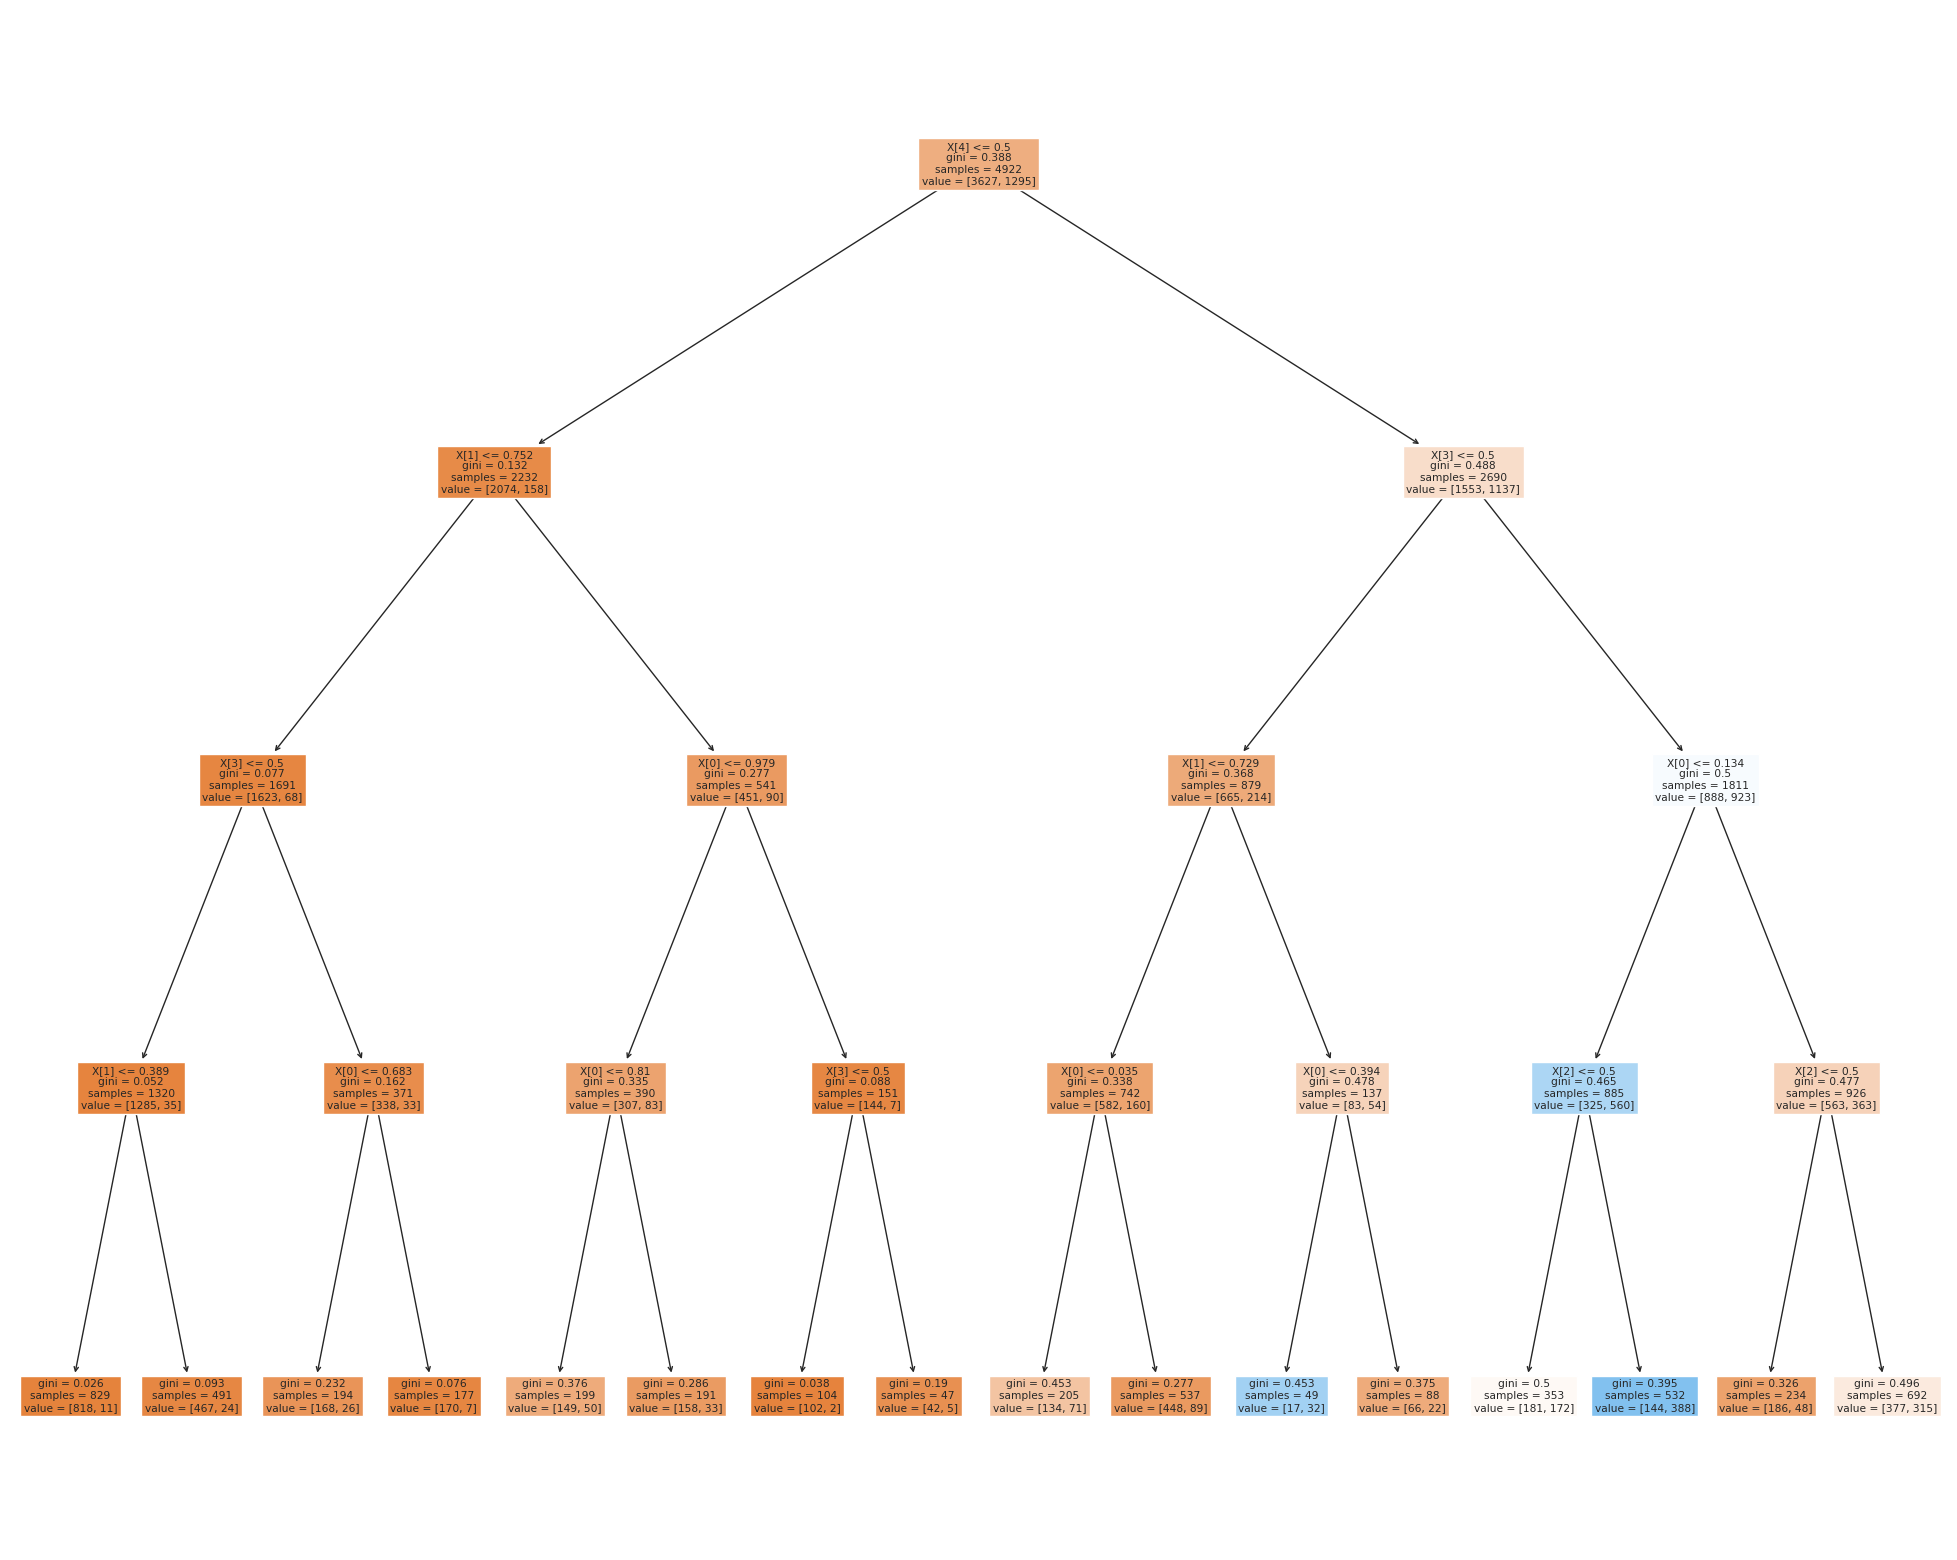

In [51]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dtc_5f,filled=True)
fig.savefig("decistion_tree_5f.png")

### Confusion matrix

In [52]:
# ophalen elementen confusion matrix
# tn = true negative (no churn)
# fp = false positive = elementen van No klasse die overlopen naar Yes klasse
# fn = false negative = elementen van Yes klasse die overlopen naar No klasse
# tp = true positive (yes churn)
tn,fp,fn,tp = confusion_matrix(y,pred_y_red).ravel()  # ravel maakt van matrix een lijst

print('\t\t real tp\t\t real tn')
print('predict tp:\t',tp,'\t\t\t',fp)
print('predict tn:\t',fn,'\t\t\t',tn)

		 real tp		 real tn
predict tp:	 420 			 161
predict tn:	 875 			 3466


<p>De echte true positives (churn yes) is gelijk aan de som van de kolom real tp.<br>
De echte true negatives (churn no) is gelijk aan de som van de kolom tn.<br>
De voorspelde true positives is gelijk aan de som van de rij predict tp.<br>
De voorspelde true negatives is gelijk aan de som van de rij predict tn.</p>
<p>Doel is om de niet diagonaal elementen naar 0 te laten naderen.</p>

In [53]:
precision = tp/(tp+fp)  # procentueel aantal voorspelde true positives die echt true positive zijn
recall = tp/(tp+fn)     # procentueel aantal juist voorspelde true positives
print('precision:',round(precision,2))
print('recall:   ',round(recall,2))

precision: 0.72
recall:    0.32


<p>Van de weglopers dat we voorspellen zijn 72% effectief weglopers (precision).<br>
Er wordt enkel enkel 32% van de weglopers gedetecteerd (recall).</p>

### Bepalen van de ROC curve (Receiver Operator Characteristic) 

<p>Wat is ROC : uitzetten van de true positive rate (= recall of tp/(tp+fn)) ten opzichte van false positive rate (= fp/(fp+tn))</p>

In [55]:
# predict_proba retourneert de probabiliteit per klasse
predictions = dtc_5f.predict_proba(X_red)
print("proba predict:",predictions, "predict:", pred_y_red)

proba predict: [[0.96045198 0.03954802]
 [0.27067669 0.72932331]
 [0.986731   0.013269  ]
 ...
 [0.83426443 0.16573557]
 [0.54479769 0.45520231]
 [0.986731   0.013269  ]] predict: [0 1 0 ... 0 0 0]


In [57]:
print("opp onder de curve:",roc_auc_score(y,predictions[:,1]))

opp onder de curve: 0.8320629385145514


In [58]:
fpr,tpr,th = roc_curve(y,predictions[:,1])
print("false positive rates:", fpr)
print("true positive rates: ", tpr)
print("bijhorende thresholds:",th)

false positive rates: [0.         0.03970223 0.0443893  0.0942928  0.19823546 0.23518059
 0.27626137 0.29445823 0.34574028 0.38930245 0.51282051 0.55913978
 0.5707196  0.69947615 0.74634684 0.77446926 1.        ]
true positive rates:  [0.         0.2996139  0.32432432 0.45714286 0.7003861  0.75521236
 0.79382239 0.81081081 0.84787645 0.87335907 0.94208494 0.96216216
 0.96602317 0.98455598 0.98996139 0.99150579 1.        ]
bijhorende thresholds: [1.72932331 0.72932331 0.65306122 0.48725212 0.45520231 0.34634146
 0.25125628 0.25       0.20512821 0.17277487 0.16573557 0.13402062
 0.10638298 0.04887984 0.03954802 0.01923077 0.013269  ]


Text(0.5, 1.0, 'ROC curve')

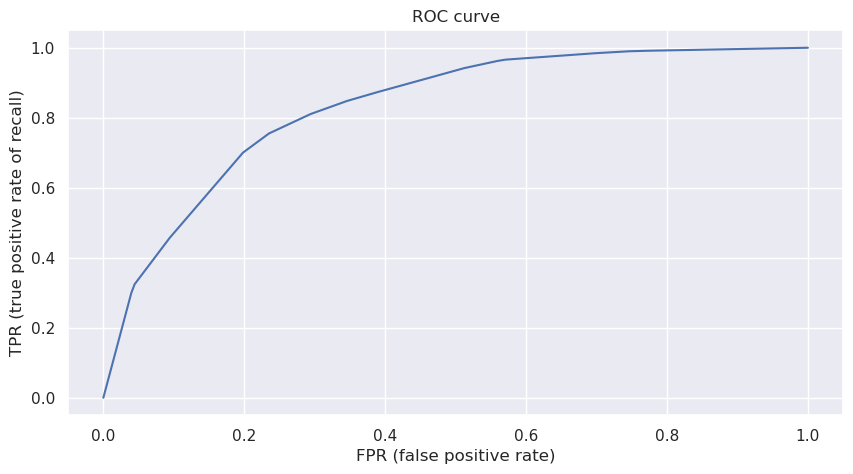

In [59]:
plt.clf()
plt.plot(fpr,tpr)
plt.xlabel('FPR (false positive rate)')
plt.ylabel('TPR (true positive rate of recall)')
plt.title('ROC curve')
# het aantal punten wordt bepaald door de indeling van de decision tree.
# het aantal nodes of blokjes in de onderste laag van de decision tree grafiek.

### Optimale threshold bepalen

In [60]:
dist = []
for i in range(len(tpr)):
    # afstand bepalen van ieder punt in de curve naar (0,1)
    # vierkantswortel((fpr-0)**2 + (tpr-1)**2)
    dist.append(((fpr[i]-0)**2+(tpr[i]-1)**2)**0.5)
print('afstanden van punten tov (0,1):', dist)

afstanden van punten tov (0,1): [1.0, 0.7015104824157193, 0.6771322093004566, 0.550985490218742, 0.35925726850866385, 0.3394567733342614, 0.3447166249553748, 0.3499974264001065, 0.37772730530323445, 0.4093828585195555, 0.5160804513860201, 0.5604185945183886, 0.5717300853287989, 0.6996466276309724, 0.7464143513680888, 0.7745158382447727, 1.0]


In [63]:
min_dist = min(dist)
idx_min_dist = dist.index(min_dist)
th_optimal = th[idx_min_dist]
print('optimale threshold:',th_optimal)
print('recall of true positive rate bij optimale threshold:',tpr[idx_min_dist])
print('correcponderende false positive rate:',fpr[idx_min_dist])

optimale threshold: 0.3463414634146341
recall of true positive rate bij optimale threshold: 0.7552123552123552
correcponderende false positive rate: 0.2351805900192997


### Predictie aan de hand van threshold 0.346

In [68]:
new_y_pred_red = []
for p in predictions[:,1]:
    if p >= 0.346:
        new_y_pred_red.append(1) # yes churn klasse
    else:
        new_y_pred_red.append(0) # no churn klasse

# ophalen elementen confusion matrix
# tn = true negative (no churn)
# fp = false positive = elementen van No klasse die overlopen naar Yes klasse
# fn = false negative = elementen van Yes klasse die overlopen naar No klasse
# tp = true positive (yes churn)
tn,fp,fn,tp = confusion_matrix(y,new_y_pred_red).ravel()  # ravel maakt van matrix een lijst

print('\t\t real tp\t\t real tn')
print('predict tp:\t',tp,'\t\t\t',fp)
print('predict tn:\t',fn,'\t\t\t',tn)
print(' ')
precision = tp/(tp+fp)  # procentueel aantal voorspelde true positives die echt true positive zijn
recall = tp/(tp+fn)     # procentueel aantal juist voorspelde true positives
print('precision:',round(precision,2))
print('recall:   ',round(recall,2))

		 real tp		 real tn
predict tp:	 978 			 853
predict tn:	 317 			 2774
 
precision: 0.53
recall:    0.76


## PCA (Principle Component Analysis)

<p>PCA wordt veel gebruikt om aan dimensie reductie te doen. Bijvoorbeeld van 20d naar 2d.</p>

In [72]:
pca = PCA()
pca.fit(X)
print('De componenten of eigenvectoren:')
print(pca.components_)
print('Corresponderende spreiding:')
print(pca.explained_variance_)
print(len(pca.explained_variance_))

De componenten of eigenvectoren:
[[-4.30976433e-04 -1.66468911e-01 -6.50696702e-02 ...  1.16060903e-02
  -1.25499495e-01  1.10619588e-01]
 [ 2.50072944e-01  1.10445773e-01  1.92589255e-01 ...  9.74759989e-02
  -1.06409657e-01 -7.71699128e-02]
 [ 2.81984788e-02 -1.22999089e-01 -2.95249845e-02 ...  7.16384262e-02
  -2.07606493e-01  9.68618296e-02]
 ...
 [ 0.00000000e+00 -5.94391875e-18 -8.78437600e-18 ...  4.74121737e-17
  -5.99454359e-18 -2.93478266e-17]
 [-0.00000000e+00 -2.99371106e-15  1.92722980e-16 ... -3.50052590e-02
  -3.50052590e-02 -3.50052590e-02]
 [ 0.00000000e+00 -2.16856728e-15  3.71167304e-17 ...  8.65544622e-02
   8.65544622e-02  8.65544622e-02]]
Corresponderende spreiding:
[2.04718202e+00 1.13445473e+00 6.85266595e-01 3.95912490e-01
 3.23032673e-01 3.07666277e-01 2.89012326e-01 2.79241797e-01
 2.62773978e-01 2.50383401e-01 2.37587047e-01 2.25525729e-01
 2.19334351e-01 2.12633465e-01 2.02041243e-01 1.92749360e-01
 1.56324691e-01 1.41126997e-01 1.30337358e-01 9.65835758e-0

In [73]:
# een transformatie doen met de 2 eerste PCA componenten
pca_2D = PCA(n_components=2)
pca_2D.fit(X)  # bepalen van de eerste 2 PCA componenten
X_tf = pca_2D.transform(X)  # transformeren van de data naar 2D
print(X_tf)

[[-0.74701936  0.75605671]
 [-0.9935561  -1.43138504]
 [ 2.72080333 -0.23185181]
 ...
 [ 2.38132261 -0.53830857]
 [-1.27380415 -0.01642842]
 [ 2.7184109  -0.18112101]]


In [74]:
# kopieren van de y dataframe naar een nieuwe dataframe
data_2d = y.copy()  
# Nieuwe dataframe uitbreiden met de getransfromeerde data
data_2d['PCA1']=X_tf[:,0]  # eerste kolom van X_tf
data_2d['PCA2']=X_tf[:,1]  # tweede kolom van X_tf
print(data_2d)

      Yes      PCA1      PCA2
1695    0 -0.747019  0.756057
1095    0 -0.993556 -1.431385
3889    0  2.720803 -0.231852
3667    0 -0.796481  0.528974
2902    0 -0.912772 -1.522907
...   ...       ...       ...
3772    1 -0.890560 -0.404927
5191    0 -0.397054  2.281452
5226    0  2.381323 -0.538309
5390    1 -1.273804 -0.016428
860     0  2.718411 -0.181121

[4922 rows x 3 columns]


In [75]:
# Hernoemen van de kolommen
data_2d.columns = ['Churn', 'PCA1', 'PCA2']
print(data_2d)

      Churn      PCA1      PCA2
1695      0 -0.747019  0.756057
1095      0 -0.993556 -1.431385
3889      0  2.720803 -0.231852
3667      0 -0.796481  0.528974
2902      0 -0.912772 -1.522907
...     ...       ...       ...
3772      1 -0.890560 -0.404927
5191      0 -0.397054  2.281452
5226      0  2.381323 -0.538309
5390      1 -1.273804 -0.016428
860       0  2.718411 -0.181121

[4922 rows x 3 columns]


<Axes: xlabel='PCA1', ylabel='PCA2'>

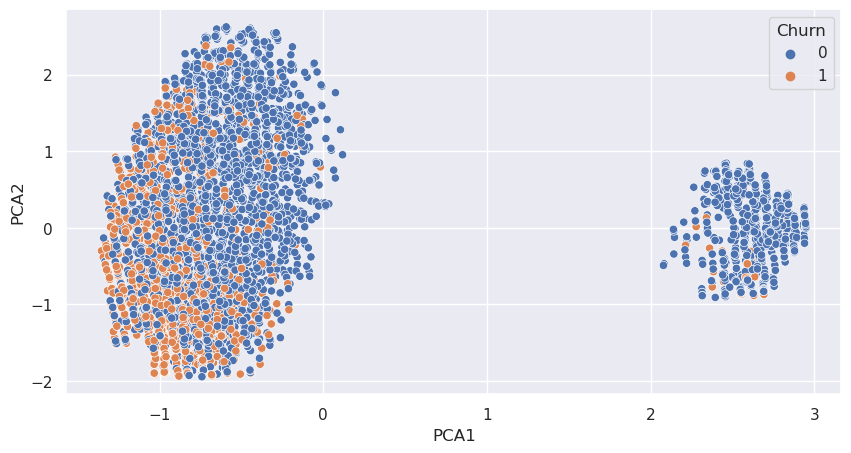

In [77]:
snb.scatterplot(x='PCA1',y='PCA2',data=data_2d,hue='Churn')

## Model kNN (k Nearest Neighbors)

In [87]:
knn = KNeighborsClassifier()
grid = {'n_neighbors':[1,2,3,4,5,6,7,8],
        'weights':['uniform','distance'],
        'algorithm':['ball_tree','kd_tree','auto'],
        'leaf_size':[10,20,30,35,40,45,50]}
# n_neighbors = aantal te checken buren
# weights = uniform -> meest aantal dichtste buren van klasse bepaalt de klasse. 
#   voorbeeld : 5 buren waarvan 3 met klasse 1, dan wordt het nieuwe punt ook klasse 1
# weights = distance -> het nieuwe punt krijgt de klasse van de dichtste buur
# algoritm en leaf_size zijn eventueel toe te passe tree algoritmes  en bijhorende parameters.
# worden gebruikt om het zoeken te versnellen.
random_cv = RandomizedSearchCV(knn,grid,cv=4,random_state=42)  # maken randomVC object
random_cv.fit(X_red,np.ravel(y))  # fitten met verschillende combinaties van hyperparameters
best_knn = random_cv.best_estimator_  # het best presterende model ophalen
pred_y_knn = best_knn.predict(X_red)  # Voorspellen met dit model (nog met leerset)
print('accuracy:',accuracy_score(y,pred_y_knn))  
# meten van de prestatie van het model mbv accuracy = (#voorspelde yes + #voorspelde no) / #totaal
print('hyperparameters voor het beste model',random_cv.best_params_)

/home/frank/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/frank/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

/home/frank/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/frank/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted

accuracy: 0.8315725314912638
hyperparameters voor het beste model {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 50, 'algorithm': 'ball_tree'}


In [85]:
# ophalen elementen confusion matrix
# tn = true negative (no churn)
# fp = false positive = elementen van No klasse die overlopen naar Yes klasse
# fn = false negative = elementen van Yes klasse die overlopen naar No klasse
# tp = true positive (yes churn)
tn,fp,fn,tp = confusion_matrix(y,pred_y_knn).ravel()  # ravel maakt van matrix een lijst

print('\t\t real tp\t\t real tn')
print('predict tp:\t',tp,'\t\t\t',fp)
print('predict tn:\t',fn,'\t\t\t',tn)
print(' ')
precision = tp/(tp+fp)  # procentueel aantal voorspelde true positives die echt true positive zijn
recall = tp/(tp+fn)     # procentueel aantal juist voorspelde true positives
print('precision:',round(precision,2))
print('recall:   ',round(recall,2))

		 real tp		 real tn
predict tp:	 768 			 302
predict tn:	 527 			 3325
 
precision: 0.72
recall:    0.59


In [88]:
predictions = best_knn.predict_proba(X_red)
print("proba predict:",predictions, "predict:", pred_y_knn)

proba predict: [[0.85714286 0.14285714]
 [0.14285714 0.85714286]
 [1.         0.        ]
 ...
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]] predict: [0 1 0 ... 0 1 0]


In [89]:
fpr,tpr,th = roc_curve(y,predictions[:,1])
print("false positive rates:", fpr)
print("true positive rates: ", tpr)
print("bijhorende thresholds:",th)

false positive rates: [0.         0.         0.00661704 0.03418803 0.08326441 0.1607389
 0.29142542 0.51612903 1.        ]
true positive rates:  [0.         0.07722008 0.2023166  0.41158301 0.59305019 0.74826255
 0.8957529  1.         1.        ]
bijhorende thresholds: [2.         1.         0.85714286 0.71428571 0.57142857 0.42857143
 0.28571429 0.14285714 0.        ]


Text(0.5, 1.0, 'ROC curve')

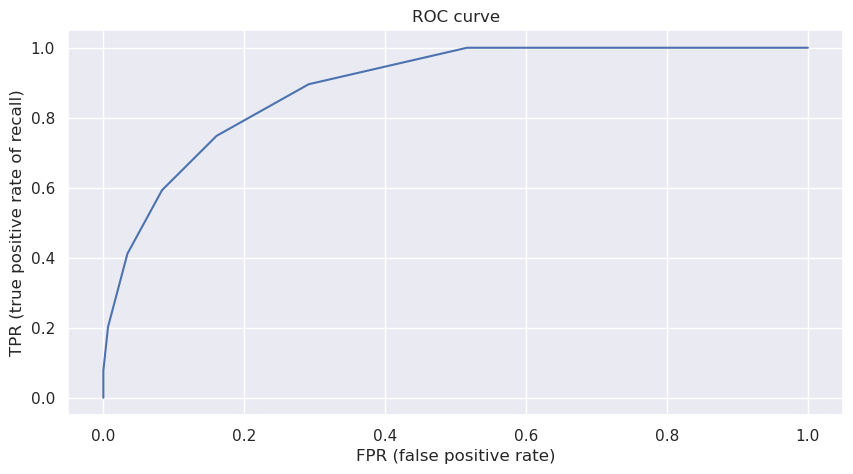

In [90]:
plt.clf()
plt.plot(fpr,tpr)
plt.xlabel('FPR (false positive rate)')
plt.ylabel('TPR (true positive rate of recall)')
plt.title('ROC curve')
# het aantal punten wordt bepaald door de indeling van de decision tree.
# het aantal nodes of blokjes in de onderste laag van de decision tree grafiek.

In [91]:
print("opp onder de curve:",roc_auc_score(y,predictions[:,1]))

opp onder de curve: 0.8902859612537033
